- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [27]:

import sys
print(sys.executable)

import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

import scipy.ndimage
import scipy

! pip install -U -q dinosaur-dycore gcsfs

c:\Users\mayeu\.venvs\venvPFE\Scripts\python.exe
2.5.1+cpu
None
False



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Learn Physic part

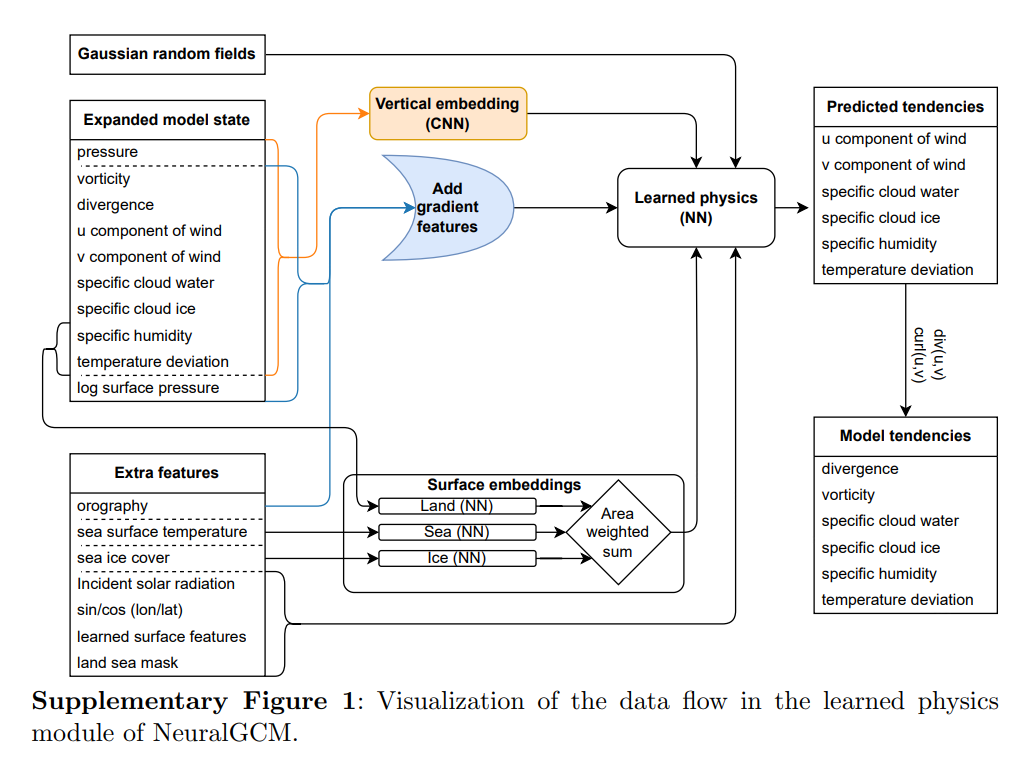

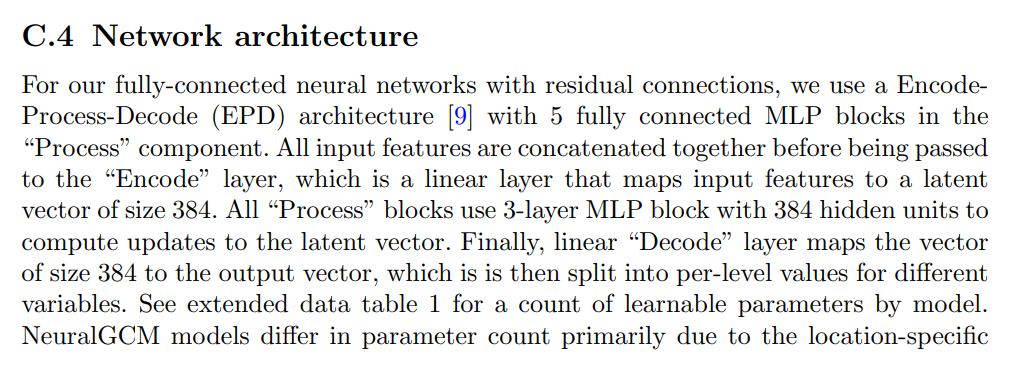

In [2]:
import xarray as xr
regridded_original_encode = xr.open_dataset("data/full_encoded_dataa.nc")
regridded_encode = xr.open_dataset("data/encoded_dataa_64x32.nc")

In [3]:
regridded_original_encode

<xarray.Dataset> Size: 232MB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 32, time: 5)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 21MB ...
    vorticity                            (level, time, longitude, latitude) float32 21MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 21MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 21MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 655kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 655kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 21MB ...
    temperature                          (time, level, longitude, latitude) float32 21MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 21MB ...

In [4]:
regridded_encode

<xarray.Dataset> Size: 15MB
Dimensions:                              (longitude: 64, level: 32, time: 5,
                                          latitude: 32)
Coordinates:
  * longitude                            (longitude) float64 512B 0.0 ... 354.4
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * latitude                             (latitude) float64 256B -85.76 ... 8...
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 1MB ...
    vorticity                            (level, time, longitude, latitude) float32 1MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 1MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 1MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 41kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 41kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 1MB ...
    temperature                          (time, level, longitude, latitude) float32 1MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 1MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 1MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 1MB ...

### Vertical embedding network

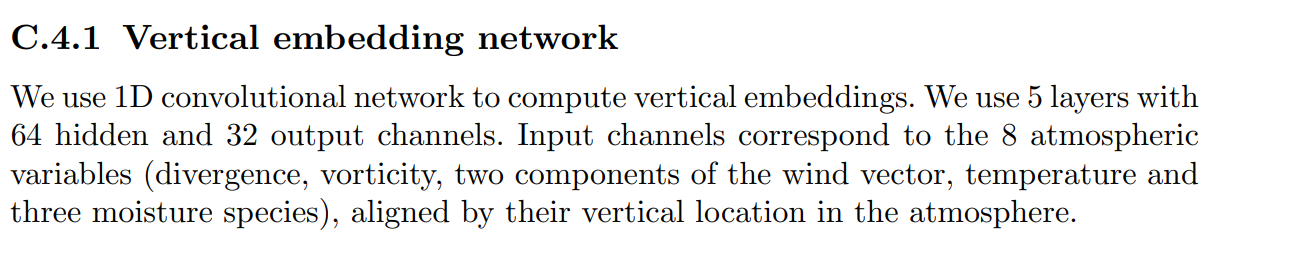

In [5]:
input_channels = 8
hidden_channels = 64
output_channels = 32
num_layers = 5
vertical_dim = 5

longitude_nodes=64
latitude_nodes=32
level_nodes = 32

x = torch.rand(16, input_channels, vertical_dim)
x.shape

torch.Size([16, 8, 5])

For the learned physics module, we gonna first generate random data.

In [6]:
vorticity = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
divergence = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
u_component_of_wind = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
v_component_of_wind = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
specific_cloud_water = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
specific_cloud_ice = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
specific_humidity = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
temperature_deviation = torch.empty((level_nodes, longitude_nodes, latitude_nodes))

def generate_data(shape):
    data = torch.normal(mean=0, std=1, size=shape).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    return torch.tensor(data)

for i in range(5):
    vorticity[i] = generate_data((longitude_nodes, latitude_nodes))
    divergence[i] = generate_data((longitude_nodes, latitude_nodes))
    u_component_of_wind[i] = generate_data((longitude_nodes, latitude_nodes))
    v_component_of_wind[i] = generate_data((longitude_nodes, latitude_nodes))
    specific_cloud_water[i] = generate_data((longitude_nodes, latitude_nodes))
    specific_cloud_ice[i] = generate_data((longitude_nodes, latitude_nodes))
    specific_humidity[i] = generate_data((longitude_nodes, latitude_nodes))
    temperature_deviation[i] = generate_data((longitude_nodes, latitude_nodes))

features = torch.stack([ 
    vorticity, 
    divergence, 
    u_component_of_wind, 
    v_component_of_wind, 
    specific_cloud_water, 
    specific_cloud_ice, 
    specific_humidity, 
    temperature_deviation
])

data = features.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
data = data.reshape(-1, 8, level_nodes)  # (batch_size=32*16, input_channels=8, sequence_length=5)

print("Shape of data tensor:", data.shape)
print("Shape of features tensor:", features.shape)

Shape of data tensor: torch.Size([2048, 8, 32])
Shape of features tensor: torch.Size([8, 32, 64, 32])


In [7]:
data.shape

torch.Size([2048, 8, 32])

In [8]:
from learnedPhysics import VerticalEmbeddingNetwork

model_VEN = VerticalEmbeddingNetwork()
output_VEN = model_VEN(data)
output_VEN = output_VEN.permute(0, 2, 1)
output_VEN = output_VEN.reshape(-1, 32)

output_VEN.shape

torch.Size([65536, 32])

### Surface embedding network

In [9]:
sea_ice_cover = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
sea_surface_temperature = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
temperature_deviation = torch.empty((level_nodes, longitude_nodes, latitude_nodes))
specific_humidity = torch.empty((level_nodes, longitude_nodes, latitude_nodes))

for i in range(level_nodes):
    sea_ice_cover[i] = generate_data((longitude_nodes, latitude_nodes))
    sea_surface_temperature[i] = generate_data((longitude_nodes, latitude_nodes))
    temperature_deviation[i] = generate_data((longitude_nodes, latitude_nodes))
    specific_humidity[i] = generate_data((longitude_nodes, latitude_nodes))

sea_input = sea_surface_temperature
ice_input = sea_ice_cover 
land_input = torch.stack([ temperature_deviation, specific_humidity])

sea_input = sea_input.permute(1, 2, 0)
sea_input = sea_input.reshape(-1, level_nodes)
sea_input = sea_input.reshape(-1, 1)

ice_input = ice_input.permute(1, 2, 0)
ice_input = ice_input.reshape(-1, level_nodes)
ice_input = ice_input.reshape(-1, 1)

land_input = land_input.permute(2, 3, 0, 1) # (latitude, longitude, variables, vertical_dim)
land_input = land_input.reshape(-1, 2, level_nodes)  # (batch_size=32*16, input_channels=8, sequence_length=5)
land_input = land_input.reshape(-1, 2)

print("Shape of sea_input tensor:", sea_input.shape)
print("Shape of ice_input tensor:", ice_input.shape)
print("Shape of land_input tensor:", land_input.shape)

Shape of sea_input tensor: torch.Size([65536, 1])
Shape of ice_input tensor: torch.Size([65536, 1])
Shape of land_input tensor: torch.Size([65536, 2])


In [10]:
from learnedPhysics import SurfaceEmbeddingNetwork, AreaWeightedSum

sea_net = SurfaceEmbeddingNetwork(surface_type='sea')
land_net = SurfaceEmbeddingNetwork(surface_type='land')
ice_net = SurfaceEmbeddingNetwork(surface_type='ice')

sea_embedding = sea_net(sea_input)
land_embedding = land_net(land_input)
ice_embedding = ice_net(ice_input)

print(sea_embedding.shape)
print(land_embedding.shape)
print(ice_embedding.shape)

torch.Size([65536, 8])
torch.Size([65536, 8])
torch.Size([65536, 8])


In [11]:
land_fraction = torch.randn(level_nodes * longitude_nodes * latitude_nodes, 1)
sea_fraction = torch.randn(level_nodes * longitude_nodes * latitude_nodes, 1)
ice_fraction = torch.randn(level_nodes * longitude_nodes * latitude_nodes, 1)

area_weighted_sum = AreaWeightedSum()
final_embedding = area_weighted_sum(land_embedding, sea_embedding, ice_embedding, land_fraction, sea_fraction, ice_fraction)

print("Final Area Weighted Sum:", final_embedding.shape)

Final Area Weighted Sum: torch.Size([65536, 8])


Output size of Vertical Embedding Module is [65536, 32] \
Output size of Surface Embedding Module is [65536, 8]

In [12]:
import torch
import torch.nn as nn

class EPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, hidden_units=384):
        super(EPDNetwork, self).__init__()

        # Encode : Couche linéaire pour encoder les entrées combinées
        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)

        # Process : Bloc MLP pour traiter le vecteur latent
        self.process_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_size, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, hidden_units),
                nn.ReLU(),
                nn.Linear(hidden_units, latent_size)
            )
            for _ in range(num_process_blocks)
        ])

        # Decode : Couche linéaire pour décoder le vecteur latent en sortie
        self.decode = nn.Linear(latent_size, 6)
    def forward(self, vertical_embedding, surface_embedding):
        # Concaténer les embeddings verticaux et de surface
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        # Encoder : projeté vers l'espace latent
        x = self.encode(x)
        
        # Process : passer à travers les blocs MLP avec connexions résiduelles
        for block in self.process_blocks:
            x_residual = x  # Connexion résiduelle
            x = block(x)
            x += x_residual 


        output = self.decode(x)
        return output

vertical_embedding_size = 32 
surface_embedding_size = 8

model_epd = EPDNetwork(vertical_embedding_size, surface_embedding_size)

vertical_embedding = output_VEN
surface_embedding = final_embedding

predicted_tendencies = model_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies.shape)

torch.Size([65536, 6])


In [13]:
""" import torch
import torch.nn as nn
from torch.nn import Transformer

class TransformerEPDNetwork(nn.Module):
    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, num_heads=8, num_encoder_layers=6, hidden_units=384):
        super(TransformerEPDNetwork, self).__init__()

        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)
        self.transformer = Transformer(d_model=latent_size, nhead=num_heads, num_encoder_layers=num_encoder_layers, dim_feedforward=hidden_units)
        self.decode = nn.Linear(latent_size, 6)

    def forward(self, vertical_embedding, surface_embedding):
        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)
        
        x = self.encode(x)

        x = x.unsqueeze(0)
        x = self.transformer(x, x) 
        x = x.squeeze(0) 
        output = self.decode(x)
        return output

vertical_embedding_size = 32
surface_embedding_size = 8

model_transformer_epd = TransformerEPDNetwork(vertical_embedding_size, surface_embedding_size)

vertical_embedding = output_VEN
surface_embedding = final_embedding

predicted_tendencies = model_transformer_epd(vertical_embedding, surface_embedding)
print(predicted_tendencies.shape) """

' import torch\nimport torch.nn as nn\nfrom torch.nn import Transformer\n\nclass TransformerEPDNetwork(nn.Module):\n    def __init__(self, vertical_embedding_size, surface_embedding_size, latent_size=384, num_process_blocks=5, num_heads=8, num_encoder_layers=6, hidden_units=384):\n        super(TransformerEPDNetwork, self).__init__()\n\n        self.encode = nn.Linear(vertical_embedding_size + surface_embedding_size, latent_size)\n        self.transformer = Transformer(d_model=latent_size, nhead=num_heads, num_encoder_layers=num_encoder_layers, dim_feedforward=hidden_units)\n        self.decode = nn.Linear(latent_size, 6)\n\n    def forward(self, vertical_embedding, surface_embedding):\n        x = torch.cat((vertical_embedding, surface_embedding), dim=-1)\n        \n        x = self.encode(x)\n\n        x = x.unsqueeze(0)\n        x = self.transformer(x, x) \n        x = x.squeeze(0) \n        output = self.decode(x)\n        return output\n\nvertical_embedding_size = 32\nsurface_embe

### Network output scaling

In [14]:
predicted_tendencies_reshape = predicted_tendencies.view(6, 32, 64, 32)
predicted_tendencies_reshape = predicted_tendencies_reshape.detach().numpy()

In [15]:
import numpy as np
import jax
rng_key = jax.random.PRNGKey(42)

divergence = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')
vorticity = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')
specific_cloud_water = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')
specific_cloud_ice = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')
specific_humidity = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')
temperature_deviation = np.empty((level_nodes, longitude_nodes, latitude_nodes), dtype='float32')

for i in range(level_nodes):
    divergence[i] = np.array(predicted_tendencies_reshape[0][i])
    vorticity[i] = np.array(predicted_tendencies_reshape[1][i])
    specific_cloud_water[i] = np.array(predicted_tendencies_reshape[2][i])
    specific_cloud_ice[i] = np.array(predicted_tendencies_reshape[3][i])
    specific_humidity[i] = np.array(predicted_tendencies_reshape[4][i])
    temperature_deviation[i] = np.array(predicted_tendencies_reshape[5][i])
    
divergence = divergence.reshape(64, 32, 32)
vorticity = vorticity.reshape(64, 32, 32)
specific_cloud_water = specific_cloud_water.reshape(64, 32, 32)
specific_cloud_ice = specific_cloud_ice.reshape(64, 32, 32)
specific_humidity = specific_humidity.reshape(64, 32, 32)
temperature_deviation = temperature_deviation.reshape(64, 32, 32)

In [16]:
output_NN = regridded_encode.mean(dim="time")

In [17]:
output_NN = output_NN.drop_vars(list(output_NN.data_vars))

In [18]:
output_NN['divergence'] = xr.DataArray(divergence, coords=output_NN.coords, dims=output_NN.dims)
output_NN['vorticity'] = xr.DataArray(vorticity, coords=output_NN.coords, dims=output_NN.dims)
output_NN['specific_cloud_water'] = xr.DataArray(specific_cloud_water, coords=output_NN.coords, dims=output_NN.dims)
output_NN['specific_cloud_ice'] = xr.DataArray(specific_cloud_ice, coords=output_NN.coords, dims=output_NN.dims)
output_NN['specific_humidity'] = xr.DataArray(specific_humidity, coords=output_NN.coords, dims=output_NN.dims)
output_NN['temperature_deviation'] = xr.DataArray(temperature_deviation, coords=output_NN.coords, dims=output_NN.dims)

In [19]:
from dynamical_core import dynamical_core, dynamical_core2, state_to_xarray

2.5.1+cpu
None
False


In [20]:
e = regridded_encode.isel(time = 0)

In [21]:
dynamical_core_xarray = output_NN.drop_vars(list(output_NN.data_vars))

In [22]:
def reshape_array(data):
    data = np.concatenate([data, data[:, -1:, :]], axis=1)
    data = data[:, :, :-1]
    data = np.transpose(data, (1, 0, 2))
    return data

In [23]:
def state_to_xarray_2(out_state) :
    divergence = out_state.divergence
    vorticity = out_state.vorticity
    log_surface_pressure = out_state.log_surface_pressure
    temperature_variation = out_state.temperature_variation
    temperature = out_state.temperature_variation
    specific_humidity = out_state.tracers['specific_humidity']
    specific_cloud_ice = out_state.tracers['specific_cloud_ice']
    specific_cloud_water = out_state.tracers['specific_cloud_water']

    divergence = reshape_array(divergence)
    vorticity = reshape_array(vorticity)
    log_surface_pressure = reshape_array(log_surface_pressure)
    temperature_variation = reshape_array(temperature_variation)
    temperature = reshape_array(temperature)
    specific_humidity =  reshape_array(specific_humidity)
    specific_cloud_ice = reshape_array(specific_cloud_ice)
    specific_cloud_water = reshape_array(specific_cloud_water)

    dynamical_core_xarray['divergence'] = xr.DataArray(divergence, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    dynamical_core_xarray['vorticity'] = xr.DataArray(vorticity, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    print(dynamical_core_xarray)
    dynamical_core_xarray['log_surface_pressure'] = xr.DataArray(log_surface_pressure, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    print(dynamical_core_xarray)
    dynamical_core_xarray['temperature_deviation'] = xr.DataArray(temperature_deviation, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    dynamical_core_xarray['temperature'] = xr.DataArray(temperature, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    dynamical_core_xarray['specific_humidity'] = xr.DataArray(specific_humidity, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    dynamical_core_xarray['specific_cloud_ice_water_content'] = xr.DataArray(specific_cloud_ice, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    dynamical_core_xarray['specific_cloud_liquid_water_content'] = xr.DataArray(specific_cloud_water, coords=dynamical_core_xarray.coords, dims=dynamical_core_xarray.dims)
    
    return dynamical_core_xarray

In [24]:
from dinosaur import primitive_equations
from dynamical_core import state_to_xarray, state_to_xarray_init

In [33]:
def trajectory_to_xarray(trajectory):

    # convert units back to SI
    target_units = {k: v.data.units for k, v in ds_init.items()}
    target_units |= {
        'vorticity': units('1/s'),
        'divergence': units('1/s'),
        'geopotential': units('m^2/s^2'),
        'vertical_velocity': units('1/s'),
    }

    ###################################################
    target_units['surface_pressure'] = units('Pa')
    ###################################################
    target_units['specific_cloud_water'] = units('kg/kg')
    ###################################################
    target_units['specific_cloud_ice'] = units('kg/kg')
    ###################################################

    orography_nodal = jax.device_put(model_coords.horizontal.to_nodal(orography), device=jax.devices('cpu')[0])
    trajectory_cpu = jax.device_put(trajectory, device=jax.devices('cpu')[0])

    traj_nodal_si = {
        k: physics_specs.dimensionalize(v, target_units[k]).magnitude
        for k, v in trajectory_cpu.items()
    }

    # build xarray
    times = float(save_every / units.hour) * np.arange(outer_steps)
    lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
    lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

    dims = ('time', 'sigma', 'longitude', 'latitude')
    ds_result = xr.Dataset(
        data_vars={
            k: (dims, v) for k, v in traj_nodal_si.items() if k != 'surface_pressure'
        },
        coords={
            'longitude': lon,
            'latitude': lat,
            'sigma': model_coords.vertical.centers[output_level_indices],
            'time': times,
            'orography': (('longitude', 'latitude'), orography_nodal.squeeze()),
        },
    ).assign(
        surface_pressure=(
            ('time', 'longitude', 'latitude'),
            traj_nodal_si['surface_pressure'].squeeze(axis=-3),
        )
    )
    return ds_result

In [34]:
from dinosaur import primitive_equations, scales
from dynamical_core import state_to_xarray

units = scales.units
ds_list = []

e = regridded_encode
dfi, raw_init_state, integrate_fn, model_coords, ds_init, orography, physics_specs, save_every, outer_steps, output_level_indices = dynamical_core(e, 5)
out_state, _ = dynamical_core2(dfi, raw_init_state, integrate_fn)

out_state = state_to_xarray_init(out_state)

for i in range(1, 5):
    tracers = {
        'specific_cloud_water': out_state['specific_cloud_liquid_water_content'],
        'specific_cloud_ice': out_state['specific_cloud_ice_water_content'],
        'specific_humidity': out_state['specific_humidity'],
        }
    
    raw_init_state = primitive_equations.State(
        vorticity = out_state['vorticity'].data,
        divergence = out_state['divergence'].data,
        temperature_variation=out_state['temperature_deviation'].data,
        log_surface_pressure=out_state['log_surface_pressure'].data,
        tracers={k: v.data for k, v in tracers.items()},
    )
    
    out_state, trajectory = dynamical_core2(dfi, raw_init_state, integrate_fn)

    out_state = state_to_xarray(out_state)

    ds_out = trajectory_to_xarray(trajectory)
    print(ds_out["time"].values)

    ds_list.append(ds_out.sel(time=1, method='nearest'))

ds_final = xr.concat(ds_list, dim="time")

ds_final

[0.         0.08333333]
[0.         0.08333333]
[0.         0.08333333]
[0.         0.08333333]


<xarray.Dataset> Size: 1MB
Dimensions:               (time: 4, sigma: 4, longitude: 64, latitude: 32)
Coordinates:
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * latitude              (latitude) float64 256B -85.76 -80.27 ... 80.27 85.76
  * sigma                 (sigma) float64 32B 0.2656 0.5156 0.7656 0.9844
  * time                  (time) float64 32B 0.08333 0.08333 0.08333 0.08333
    orography             (longitude, latitude) float32 8kB ...
Data variables:
    divergence            (time, sigma, longitude, latitude) float32 131kB ...
    geopotential          (time, sigma, longitude, latitude) float32 131kB ...
    specific_cloud_ice    (time, sigma, longitude, latitude) float32 131kB ...
    specific_cloud_water  (time, sigma, longitude, latitude) float32 131kB ...
    specific_humidity     (time, sigma, longitude, latitude) float32 131kB ...
    temperature           (time, sigma, longitude, latitude) float32 131kB ...
    u_component_of_wind   (time, sigma, longitude, latitude) float32 131kB ...
    v_component_of_wind   (time, sigma, longitude, latitude) float32 131kB ...
    vertical_velocity     (time, sigma, longitude, latitude) float32 131kB ...
    vorticity             (time, sigma, longitude, latitude) float32 131kB ...
    surface_pressure      (time, longitude, latitude) float32 33kB ...